In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv


In [2]:
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [3]:
train_df = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv')

In [4]:
X = train_df.drop(columns=['ID', 'y'])
y = train_df.y

In [5]:
pt = PowerTransformer()

data = ['Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']

pt.fit(X[data])

transformed_data = pt.transform(X[data])

X[data] = transformed_data

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [6]:
X['Area'] = np.log10(X.Area)
X['ConvexArea'] = np.log10(X.ConvexArea)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [8]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [9]:
def plot_confusion_matrix(clf, true_values, predicted_values):
    plt.figure(figsize = (8, 7))
    sns.heatmap(confusion_matrix(true_values, predicted_values),
                annot = True,
                fmt = ".0f",
                cmap = "coolwarm",
                linewidths = 2, 
                linecolor = "white",
                xticklabels = le.inverse_transform(clf.classes_),
                yticklabels = le.inverse_transform(clf.classes_))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Confusion matrix on the testing data")
    plt.show()

Training Accuarcy =  0.9939692307692307


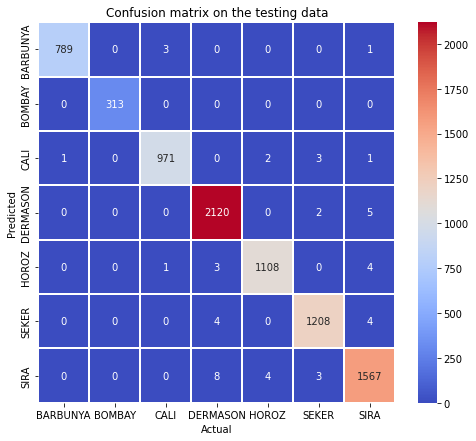

Validation Accuarcy =  0.9368770764119602


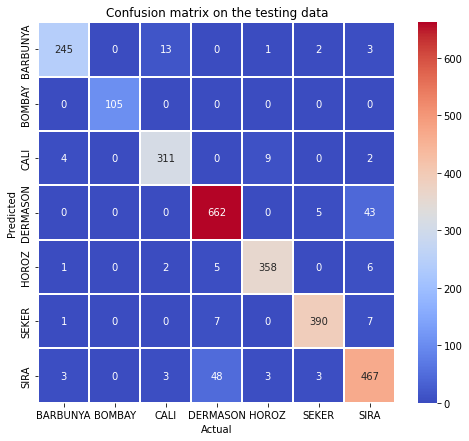

In [10]:
param_dist = {'learning_rate': 0.2,
              'max_depth': 7,
              'n_estimators': 65,
              'random_state': 42,
              'verbosity': 0,
              'subsample':0.4,
              'use_label_encoder':False
             }

clf = XGBClassifier(**param_dist)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
print('Training Accuarcy = ', f1_score(y_train, y_pred, average='micro'))
plot_confusion_matrix(clf, y_train, y_pred)

y_pred = clf.predict(X_test)
print('Validation Accuarcy = ', f1_score(y_test, y_pred, average='micro'))
plot_confusion_matrix(clf, y_test, y_pred)

In [11]:
test_df = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv')
X_test = test_df.drop(columns=['ID'])

transformed_data = pt.transform(X_test[data])

X_test[data] = transformed_data

X_test['Area'] = np.log10(X_test.Area)
X_test['ConvexArea'] = np.log10(X_test.ConvexArea)

y_test_predicted = clf.predict(X_test)

y_test_predicted = le.inverse_transform(y_test_predicted)

test_df['y'] = y_test_predicted

test_df.head()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,10834,57659,955.434,387.757607,196.625782,1.972059,0.861896,60188,270.949661,0.620790,0.957982,0.793735,0.698760,0.006725,0.000989,0.488266,0.962889,HOROZ
1,10835,28772,630.362,229.990785,159.609367,1.440960,0.719993,29127,191.399185,0.767458,0.987812,0.909913,0.832204,0.007994,0.002365,0.692563,0.997956,DERMASON
2,10836,54677,911.022,308.853903,226.398571,1.364204,0.680198,55858,263.850182,0.753013,0.978857,0.827860,0.854288,0.005649,0.001856,0.729808,0.995607,BARBUNYA
3,10837,24827,578.304,214.192699,147.788172,1.449322,0.723831,25121,177.794033,0.716508,0.988297,0.932871,0.830066,0.008627,0.002526,0.689009,0.998596,DERMASON
4,10838,141850,1432.847,524.923471,346.910920,1.513136,0.750492,143680,424.981211,0.804617,0.987263,0.868240,0.809606,0.003701,0.000981,0.655462,0.991803,BOMBAY


In [12]:
test_df[['ID', 'y']].to_csv('submission.csv', index=False)